# 📖 Introduction 

该项目的目标是开发一个深度学习模型，该模型可以准确地将面部表情分为七类之一：愤怒、厌恶、恐惧、快乐、悲伤、惊讶和中立。我们将使用卷积神经网络 （CNN） 来训练我们的模型，因为它们已被证明在图像分类任务中很有效。我们的方法涉及在 FER-2013 数据集上从头开始训练 CNN 模型

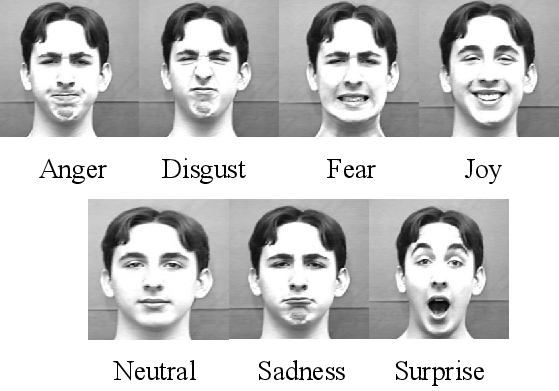



# 💾 Data

FER-2013 数据集由 48x48 像素的人脸灰度图像组成，这些图像已被自动注册为居中，并在每张图像中占据相似的空间。该数据集包含 24400 张图像，其中训练集中有 22968 个示例，公共测试集中有 1432 个示例。

# 🛠 Preprocessing

在本节中，我们将使用数据生成器和数据增强来训练使用 FER-2013 数据集进行人类情感检测的深度学习模型。由于数据集的大小和复杂性，一次将所有图像加载到内存中是不切实际的。因此，我们将在训练期间使用数据生成器动态生成批量图像，这将使我们能够在整个数据集上有效地训练我们的模型。

此外，我们还将对训练图像应用各种数据增强技术，如旋转、移位和翻转。 这将有助于增加训练集的规模和多样性，从而提高深度学习模型的性能。 通过在训练过程中引入可变性，数据扩增还有助于防止过拟合，过拟合是指模型过于贴近训练集，在新的未知数据上表现不佳。

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_dir = "./archive/train" # 包含训练数据的目录
test_dir = "./archive/test"  # 包含验证数据的目录

In [9]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # 图像宽度随机偏移，最多可偏移图像宽度的 10%
    height_shift_range = 0.1,       # 图像高度随机偏移，最多可偏移图像高度的 10%
    horizontal_flip = True,         # 随机对图像进行水平翻转
    rescale = 1./255,               # 将图像的像素值重新缩放到 0 到 1 之间
    validation_split = 0.2          # 预留 20% 的数据用于验证集
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # 将图像的像素值重新缩放到 0 到 1 之间
    validation_split = 0.2          # 预留 20% 的数据用于验证集
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # 包含训练数据的目录
    target_size = (48, 48),          # 将所有图像的大小调整为 48x48 像素
    batch_size = 64,                 # 每个批次中的图像数量
    color_mode = "grayscale",        # 将图像转换为灰度图
    class_mode = "categorical",      # 将图像分类为 7 个类别
    subset = "training"              # 使用数据的训练子集
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # 包含验证数据的目录
    target_size = (48, 48),          # 将所有图像的大小调整为 48x48 像素
    batch_size = 64,                 # 每个批次中的图像数量
    color_mode = "grayscale",        # 将图像转换为灰度图
    class_mode = "categorical",      # 将图像分类为 7 个类别
    subset = "validation"            # 使用数据的验证子集
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Modeling 

## CNN Model

为了开发CNN架构，我们将从定义第一个卷积层中的输入层和过滤器数量开始。然后，我们将添加额外的卷积层，过滤器数量不断增加，然后是最大池化层，以减少特征图的空间维度。在卷积层之后，我们将使用ReLU激活添加完全连接的层来对情绪进行分类。

我们将试验不同数量的卷积层、滤波器大小和全连接层，以优化模型性能。此外，我们将使用dropout和批量归一化等技术来防止过度拟合并提高模型的泛化能力。

In [14]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
import tensorflow as tf

# 定义模型架构
model = Sequential()

# 使用 Input 层指定输入形状
model.add(Input(shape=(48, 48, 1)))

# 添加一个卷积层，有 32 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# 添加一个批量归一化层
model.add(BatchNormalization())
# 添加第二个卷积层，有 64 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# 添加第二个批量归一化层
model.add(BatchNormalization())
# 添加一个最大池化层，池化大小为 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加一个丢弃层，丢弃率为 0.25
model.add(Dropout(0.25))

# 添加第三个卷积层，有 128 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# 添加第三个批量归一化层
model.add(BatchNormalization())
# 添加第四个卷积层，有 128 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# 添加第四个批量归一化层
model.add(BatchNormalization())
# 添加一个最大池化层，池化大小为 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加一个丢弃层，丢弃率为 0.25
model.add(Dropout(0.25))

# 添加第五个卷积层，有 256 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# 添加第五个批量归一化层
model.add(BatchNormalization())
# 添加第六个卷积层，有 256 个过滤器，3x3 的卷积核大小，使用 relu 激活函数
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# 添加第六个批量归一化层
model.add(BatchNormalization())
# 添加一个最大池化层，池化大小为 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加一个丢弃层，丢弃率为 0.25
model.add(Dropout(0.25))

# 将卷积层的输出展平为一维向量
model.add(Flatten())
# 添加一个全连接层，有 256 个神经元，使用 relu 激活函数
model.add(Dense(256, activation='relu'))
# 添加第七个批量归一化层
model.add(BatchNormalization())
# 添加一个丢弃层，丢弃率为 0.5
model.add(Dropout(0.5))
# 添加一个全连接层，有 7 个神经元（每个类别对应一个），使用 softmax 激活函数
model.add(Dense(7, activation='softmax'))

# 编译模型，使用分类交叉熵损失函数、adam 优化器，并以准确率作为评估指标
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 定义回调函数
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',  # 修改文件路径以 .weights.h5 结尾
    monitor='val_accuracy',  # 监控验证集的准确率
    save_best_only=True,  # 仅保存验证集指标表现最佳的模型权重
    save_weights_only=True,  # 仅保存模型的权重，而非整个模型
    mode='max',  # 由于监控的是准确率，希望该指标越大越好，所以设置为 'max'
    verbose=1  # 训练过程中打印保存信息，1 表示打印详细信息
)

# 使用回调函数训练模型
history = model.fit(
    train_generator,  # 训练数据生成器
    steps_per_epoch=len(train_generator),  # 每个 epoch 中的步数，等于训练数据生成器的长度
    epochs=50,  # 训练的轮数
    validation_data=validation_generator,  # 验证数据生成器
    validation_steps=len(validation_generator),  # 验证过程中的步数，等于验证数据生成器的长度
    callbacks=[checkpoint_callback]  # 使用定义好的回调函数
)

Epoch 1/50


E:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.1701 - loss: 2.9297  
Epoch 1: val_accuracy improved from -inf to 0.18855, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 141s 379ms/step - accuracy: 0.1702 - loss: 2.9292 - val_accuracy: 0.1885 - val_loss: 1.9683
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2115 - loss: 2.4684  
Epoch 2: val_accuracy improved from 0.18855 to 0.31564, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 123s 342ms/step - accuracy: 0.2115 - loss: 2.4683 - val_accuracy: 0.3156 - val_loss: 1.7734
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2519 - loss: 2.2632  
Epoch 3: val_accuracy improved from 0.31564 to 0.36732, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 122s 340ms/step - accuracy: 0.2520 - loss: 2.2631 - val_accuracy: 0.3673 - val_loss: 1.6763
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2824 - loss: 2.0977  


## Evaluation

### Training and validation loss curves

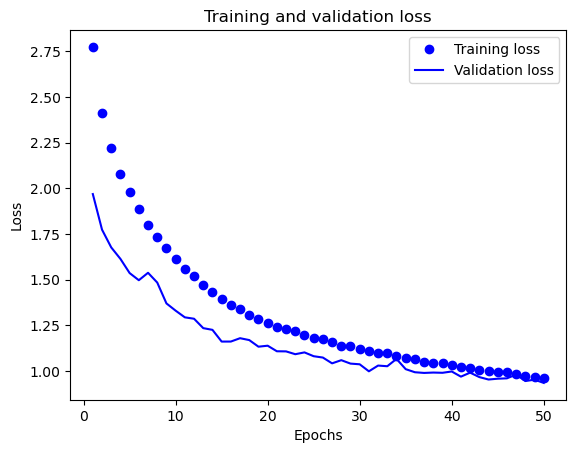

In [22]:
import matplotlib.pyplot as plt
# 绘制训练和验证损失
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training and validation accuracy curves

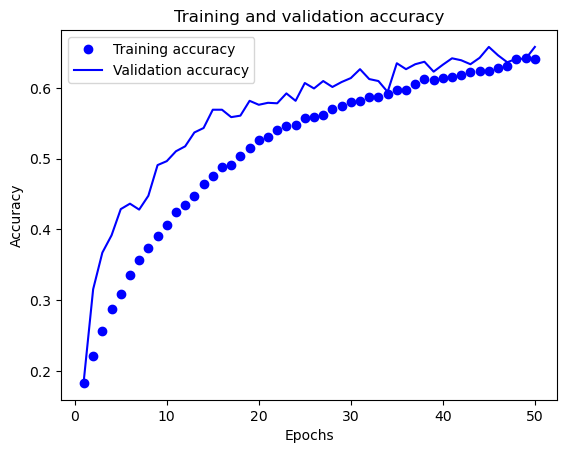

In [24]:
#绘制训练和验证精度
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step 


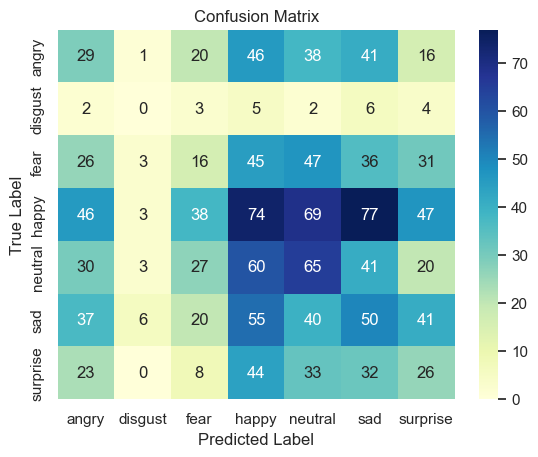

In [28]:
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()